## Importando librerías

In [1]:
# Librearías tensorflow
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, Activation, BatchNormalization)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Librerías de apoyo
import numpy as np
import matplotlib.pyplot as plt

## Carga de datos

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

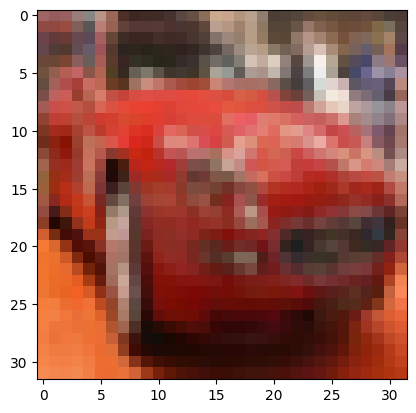

In [3]:
# Mostremos una imagen de ejemplo
plt.imshow(x_train[5]);

## Limpieza de datos

In [4]:
# Normalizamos los datos
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# calculamos la media y la desviación estándar
median  = np.median(x_train)
std = np.std(x_train)
# Normalizamos utilizando la media y la desviación estándar
x_train = (x_train - median) / (std+1e-7) # sumamos 1e-7 para evitar división por cero
x_test = (x_test - median) / (std+1e-7)

In [5]:
num_classes = len(np.unique(y_train))
# Convertimos las etiquetas a one-hot
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [6]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## División de datos

In [7]:
# Dividimos los datos de entrenamiento en entrenamiento y validación
x_training, x_val = x_train[5000:], x_train[:5000]
y_training, y_val = y_train[5000:], y_train[:5000]

# Forma de los datos
print('x_training shape:', x_training.shape[0])
print('x_val shape:', x_val.shape[0])
print('x_test shape:', x_test.shape[0])


x_training shape: 45000
x_val shape: 5000
x_test shape: 10000


## Creación del modelo

In [8]:
base_filtros = 32 # Número de filtros base
kernel_size = (3, 3) # Tamaño de los filtros
w_regularizer = 1e-4 # Peso de la regularización

In [9]:
# Modelo secuencial
model = Sequential()
## Convolución 1
model.add(Conv2D(base_filtros, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer),
                    input_shape=x_training.shape[1:]))
model.add(Activation('relu')) # Función de activación
model.add(BatchNormalization()) # Normalización de los datos
## Convolución 2
model.add(Conv2D(base_filtros, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) # Max pooling
model.add(Dropout(0.2)) # Dropout del 20%
## Convolución 3
model.add(Conv2D(base_filtros * 2, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
## Convolución 4
model.add(Conv2D(base_filtros * 2, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
## Convolución 5
model.add(Conv2D(base_filtros * 4, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
## Convolución 6
model.add(Conv2D(base_filtros * 4, kernel_size, padding='same',
                    kernel_regularizer=regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
## Clasificación
model.add(Flatten()) # Aplanamos los datos
model.add(Dense(num_classes, activation='softmax')) # Capa de salida
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

## Data Augmentation

In [10]:
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

## Compilación del modelo

In [11]:
from tensorflow.keras import optimizers

In [12]:
model.compile(loss='categorical_crossentropy', # Función de pérdida
                optimizer=optimizers.Adam(), # Optimizador
                metrics=['accuracy']) # Métricas a monitorear

In [13]:
# Entrenamos el modelo
#hist = model.fit(x_training, y_training, batch_size=32, epochs=100,
#                    validation_data=(x_val, y_val),
#                    verbose=2, shuffle=True)

### Callbacks

In [14]:
checkpoint = ModelCheckpoint(
    '../models/mi_mejor_modelo.h5',
    verbose=1,
    save_best_only=True,
    monitor='val_accuracy'
)

## Entrenamiento del modelo

In [15]:
hist = model.fit(datagen.flow(x_training, y_training, batch_size=128),
          callbacks=[checkpoint],
          steps_per_epoch=x_training.shape[0] // 128, 
          epochs=120,
          verbose=2,
          validation_data=(x_val, y_val)
         )

Epoch 1/120

Epoch 1: val_accuracy improved from -inf to 0.30360, saving model to ../models\mi_mejor_modelo.h5
351/351 - 65s - loss: 2.2492 - accuracy: 0.3222 - val_loss: 2.1356 - val_accuracy: 0.3036 - 65s/epoch - 186ms/step
Epoch 2/120

Epoch 2: val_accuracy improved from 0.30360 to 0.43760, saving model to ../models\mi_mejor_modelo.h5
351/351 - 49s - loss: 1.7084 - accuracy: 0.4305 - val_loss: 1.7694 - val_accuracy: 0.4376 - 49s/epoch - 140ms/step
Epoch 3/120

Epoch 3: val_accuracy improved from 0.43760 to 0.51700, saving model to ../models\mi_mejor_modelo.h5
351/351 - 59s - loss: 1.5161 - accuracy: 0.4918 - val_loss: 1.4792 - val_accuracy: 0.5170 - 59s/epoch - 167ms/step
Epoch 4/120

Epoch 4: val_accuracy improved from 0.51700 to 0.54660, saving model to ../models\mi_mejor_modelo.h5
351/351 - 56s - loss: 1.3674 - accuracy: 0.5400 - val_loss: 1.4287 - val_accuracy: 0.5466 - 56s/epoch - 158ms/step
Epoch 5/120

Epoch 5: val_accuracy improved from 0.54660 to 0.58420, saving model to ..

## Resultados

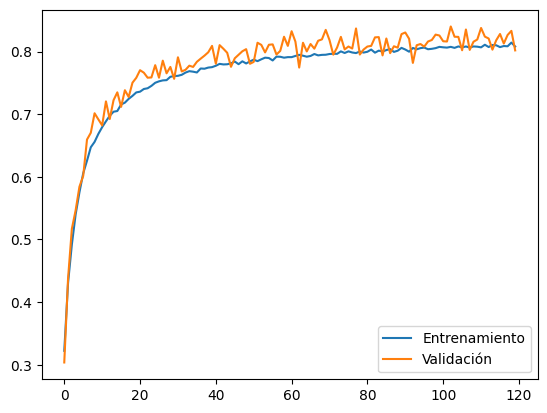

In [16]:
# Graficamos los resultados
plt.plot(hist.history['accuracy'], label='Entrenamiento')
plt.plot(hist.history['val_accuracy'], label='Validación')
plt.legend()
plt.show()

## Evaluación del modelo

In [18]:
model2 = model
model2.load_weights('../models/mi_mejor_modelo.h5') # Cargamos los pesos del modelo

In [19]:
# Evaluamos el modelo
model2.evaluate(x_test, y_test)

313/313 [==============================] - 4s 14ms/step - loss: 0.6350 - accuracy: 0.8316


[0.6349632143974304, 0.83160001039505]